In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import math
import copy
import spacy
import pathlib
from pathlib import Path
import csv
import numpy as np
from torchtext.data.metrics import bleu_score
from funnel_transformer_conan import *
from data_loader import *
from data_loader_full import *
import datetime

from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/funnel_experiment2')

/home/aipex6/anaconda3/envs/conan_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## train test split(or abridged)

In [10]:
class split_csv():
    def __init__(self, Generate_train_test_split:bool, create_abridged: bool, abridged_size: int):
        """_summary_

        Args:
            abridged (bool): Use the generated abridged dataset 

        Returns:
            _type_: _description_
        """
        self.Generate_train_test_split = Generate_train_test_split
        self.create_abridged = create_abridged
        self.abridged_size = abridged_size
        self.full_dataset_path = Path("data/en-fr.csv")
        self.abridged_dataset_path = Path("data/en-fr-training.csv")
        
        self.en_tokenizer = get_tokenizer(tokenizer='spacy',language='en_core_web_sm')
        self.fr_tokenizer = get_tokenizer(tokenizer='spacy',language='fr_core_news_sm')
        
        self.process()
        pass
    
    def process(self):
         # Create abridged dataset if it doesnt exist and load either full or abridged data into self.ds 
        # full_dataset_path = 'data/en-fr.csv'
        # abridged_dataset_path = 'data/en-fr-abridged.csv'
        self.full_dataset_path.parent.mkdir(parents=True, exist_ok=True) # make datafolder if it doesn't exist
        
        # Check if the full dataset exists
        if not self.full_dataset_path.exists():
            raise FileNotFoundError("The full dataset does not exist. Please download it from https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset/data and place in the /data folder.")
        
        # Create the abridged dataset if it does not exist
        if  self.Generate_train_test_split:      
            print("Creating train test dataset csvs...")
            print("reading full dataset...")
            full_dataset = pd.read_csv(self.full_dataset_path,encoding="utf-8", keep_default_na=False)
            if self.create_abridged:
                print("splitting abridged")
                abridged_dataset = full_dataset.head(self.abridged_size)
                print("splitting abridged train-test")
                abridged_dataset_train = abridged_dataset.head(int(self.abridged_size*0.9))
                abridged_dataset_val = abridged_dataset.tail(int(self.abridged_size*0.1))
                abridged_dataset_train.to_csv("data/en-fr-abridged-train.csv", index=False)
                abridged_dataset_val.to_csv("data/en-fr-abridged-val.csv", index=False)
            else:
                print("splitting fulldata train-test")
                training_len = int(len(full_dataset)*0.8)
                testing_len = int(len(full_dataset)-len(full_dataset)*0.9)

                abridged_dataset_training = full_dataset[:training_len]
                abridged_dataset_validation = full_dataset[training_len:training_len+testing_len]
                abridged_dataset_testing = full_dataset[training_len+testing_len:]
                del full_dataset

                print("Creating full data csvs...")
                abridged_dataset_training.to_csv("data/en-fr-train.csv", index=False)
                abridged_dataset_validation.to_csv("data/en-fr-val.csv", index=False)
                abridged_dataset_testing.to_csv("data/en-fr-test.csv", index=False)
            
        pass



In [4]:
_ = split_csv(Generate_train_test_split=True,create_abridged=True, abridged_size=1000000)

Creating train test dataset csvs...
reading full dataset...
splitting abridged
splitting abridged train-test


## Get the sequence distribution

In [3]:
en_tokenizer = get_tokenizer(tokenizer='spacy',language='en_core_web_sm')
fr_tokenizer = get_tokenizer(tokenizer='spacy',language='fr_core_news_sm')

In [4]:
def get_the_sequence_distribution(ds,en_tokenizer,fr_tokenizer):
    en_seq_len_list = []
    fr_seq_len_list = []
    for i in tqdm(range(len(ds))):
        en_seq_len_list.append(len(en_tokenizer(ds['en'][i].lower())))
        fr_seq_len_list.append(len(fr_tokenizer(ds['fr'][i].lower())))

    return en_seq_len_list, en_seq_len_list

In [5]:
ds = pd.read_csv("data/en-fr.csv",encoding="utf-8", keep_default_na=False)
en_seq_list, fr_seq_list = get_the_sequence_distribution(ds,en_tokenizer, fr_tokenizer)

100%|██████████| 22520376/22520376 [30:48<00:00, 12182.79it/s]


/tmp/ipykernel_401104/1308379509.py:37: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


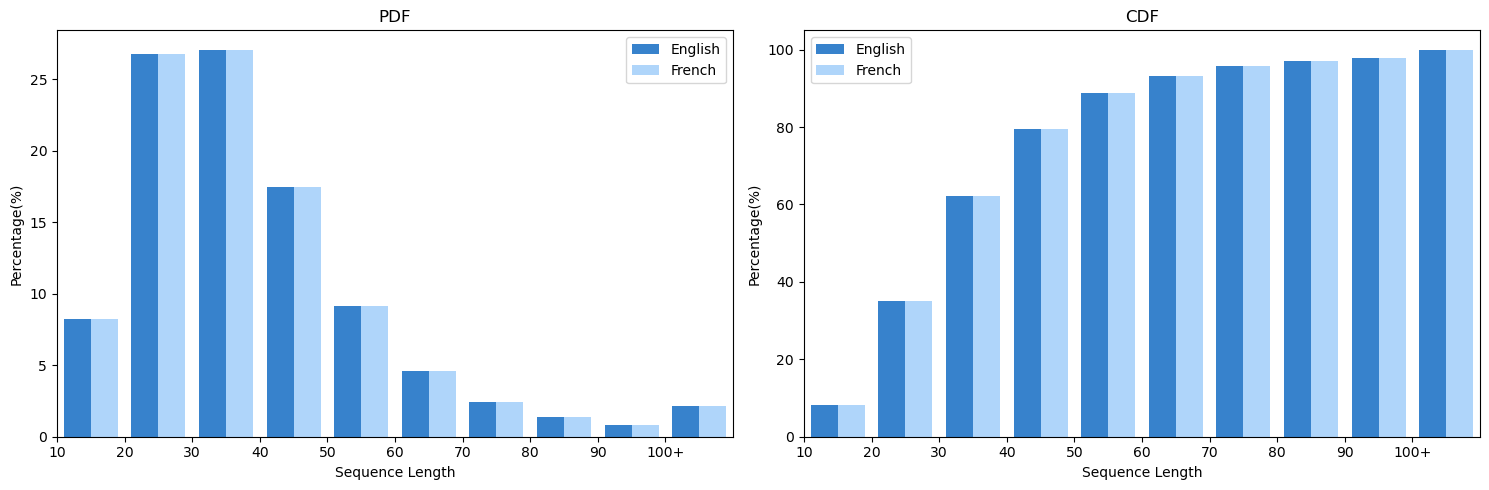

In [7]:

en_seq_list = np.array(en_seq_list)
fr_seq_list = np.array(fr_seq_list)
bins = np.arange(0,110,10)
fig, ax = plt.subplots(1,2,figsize=(15, 5))
ax[1].hist([np.clip(en_seq_list, 0,100), np.clip(fr_seq_list, 0, 100)],cumulative=True,
                            bins=bins, color=['#3782CC', '#AFD5FA'], weights=[np.full(len(en_seq_list),100)/len(en_seq_list), np.full(len(en_seq_list),100) / len(en_seq_list)], label=['English', 'French'])
xlabels = bins[1:].astype(int).astype(str)
xlabels[-1] += '+'

N_labels = len(xlabels)
ax[1].set_xlim([0, 100])
ax[1].set_xticks(10 * np.arange(N_labels))
ax[1].set_xticklabels(xlabels)
ax[1].set_ylabel("Percentage(%)")
ax[1].set_xlabel("Sequence Length")
ax[1].legend()
ax[1].set_title("CDF")
fig.tight_layout()

ax[0].hist([np.clip(en_seq_list, 0,100), np.clip(fr_seq_list, 0, 100)],
                            bins=bins, color=['#3782CC', '#AFD5FA'], weights=[np.full(len(en_seq_list),100)/len(en_seq_list), np.full(len(en_seq_list),100) / len(en_seq_list)], label=['English', 'French'])
xlabels = bins[1:].astype(int).astype(str)
xlabels[-1] += '+'

N_labels = len(xlabels)
ax[0].set_xlim([0, 100])
ax[0].set_xticks(10 * np.arange(N_labels))
ax[0].set_xticklabels(xlabels)
ax[0].set_ylabel("Percentage(%)")
ax[0].set_xlabel("Sequence Length")
ax[0].legend()
ax[0].set_title("PDF")
fig.tight_layout()

In [ ]:
frequency_greater_50 = (en_seq_list>0).sum()
frequency_greater_50/len(en_seq_list)

In [ ]:
mean_en = np.median(en_seq_list)
mean_en

## Create the dictionaries and tokenized data

In [14]:
def lang_organizer(lang):
    vocabs = list(lang.word2index.keys())
    for keys in vocabs:
        # check if the number of occurence in that key is small
        if lang.word2count[keys]<10:
            # the vocab keys appeared less than 10 times
            index = lang.word2index[keys]
            if index > 35:
                # remove all the stuff in the dictionaries and change the n_words
                del lang.word2index[keys]
                del lang.index2word[index]
                del lang.word2count[keys]
                lang.n_words -= 1
                
    vocabs = list(lang.index2word.values())
    index = [*range(len(vocabs))]
    word2index1 = {}
    index2word1 = {}
    i = 0
    for words in vocabs:
        if words not in word2index1:
            word2index1[words] = i
            index2word1[i] = words
            i += 1
    lang.word2index = word2index1
    lang.index2word1 = index2word1
    return lang

In [15]:
def read_lang(ds, eng_str="en", fr_str="fr"):
    # return if the dataformat is wrong
    if type(ds) != pd.core.frame.DataFrame:
        raise TypeError("Wrong dataframe format!")
        
    print("Reading the dataframe and storing untokenized pairs...")
    pairs = [(ds[eng_str][i], ds[fr_str][i]) for i in tqdm(range(len(ds)))]
    
    # create the class objects of Langs for English and French to count the 
    eng_lang = Langs("en")
    fr_lang = Langs("fr")
    return eng_lang, fr_lang, pairs

In [16]:
def string_to_token_list(sequence, lang):
        """Tokenize a sequence string in the given english/french language and return the list of tokens.

        Args:
            sequence (string): _description_
            lang (_type_): _description_
            en_tokenizer (_type_): _description_
            fr_tokenizer (_type_): _description_

        Returns:
            _type_: _description_
        """
        max_seq_length = 1000
        token_list = []
        if lang.lang == "en":
            words = en_tokenizer(sequence.lower())
        else:
            words = fr_tokenizer(sequence.lower())
            
        # truncate the word list if it exceeds the max allowed sequence length
        words = words[:max_seq_length - 2] # -2 is to account for the appended SOS and EOS token
        
        token_list.append(CustomTokens.SOS.value)
        for word in words:
            if word in lang.word2index:
                token_list.append(lang.word2index[word])
            else:
                token_list.append(CustomTokens.UNK.value)
        
        token_list.append(CustomTokens.EOS.value)
        
        # # pad the remainder of the token list 
        # while len(token_list) < max_seq_length:
        #     token_list.append(CustomTokens.PAD.value)
        
        return token_list

def string_data_to_tokens(data, en_lang, fr_lang, filename):
    """Create tokenized pairs of english and french sentences

    Args:
        data (_type_): Dictionary of english and french sentences

    Returns:
        _type_: _description_
    """
    tokenized_data = []
    fr_string = "_fr.csv"
    en_string = "_en.csv"
    print("Creating tokenized pairs of english and french sentences...")
    
    with open(filename+en_string, 'w') as csvfile1, open(filename+fr_string, 'w') as csvfile2:  
        # creating a csv writer object  
        csvwriter1 = csv.writer(csvfile1)  
        csvwriter2 = csv.writer(csvfile2)
        for i in tqdm(range(len(data))):
        # writing the fields  
            csvwriter1.writerow(string_to_token_list(data[i][0], en_lang))  
            csvwriter2.writerow(string_to_token_list(data[i][1], fr_lang))  

    return 1


In [19]:
def data_preprocessing(ds, training_data: bool, eng_str="en", fr_str="fr", ):
    """_summary_

    Args:
        en_tokenizer (_type_): _description_
        fr_tokenizer (_type_): _description_
        eng_str (str, optional): _description_. Defaults to "en".
        fr_str (str, optional): _description_. Defaults to "fr".
        data_pd (_type_, optional): _description_. Defaults to None.
        index_output (bool, optional): _description_cuda. Defaults to True.

    Returns:
        _type_: _description_
    """
    # initialize the language classes and get the data pairs (English, France)
    en_lang, fr_lang, data_pairs = read_lang(eng_str=eng_str, fr_str=fr_str, ds=ds) # Initialize language objects
    if training_data:
        print("Adding training set sentences to Langs amd geting data pairs...")
        for i in tqdm(range(len(data_pairs))): # create language dictionaries
            en_lang.addSentence(data_pairs[i][0].lower(), en_tokenizer, fr_tokenizer)
            fr_lang.addSentence(data_pairs[i][1].lower(), en_tokenizer, fr_tokenizer)
        # organize the langs
        print("Organizing Langs...")
        en_lang = lang_organizer(en_lang)
        fr_lang = lang_organizer(fr_lang)
        # save the langs into pickle files
        with open(f'data/en_lang_abridged_90.pickle', 'wb') as handle:
            pickle.dump(en_lang, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f'data/fr_lang_abridged_90.pickle', 'wb') as handle:
            pickle.dump(fr_lang, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        print("Adding validations set sentences, so importing training set dictionaries...")
        with open(f'data/en_lang_abridged_90.pickle', 'rb') as handle:
            en_lang = pickle.load(handle)
        with open(f'data/fr_lang_abridged_90.pickle', 'rb') as handle:
            fr_lang = pickle.load(handle)

    print("Converting strings to tokens...")
    data_pairs = string_data_to_tokens(data_pairs,en_lang, fr_lang,"data/tokenized_test") # converts sequence to tokens
    print("Done Converting")
    #  return en_lang, fr_lang, data_pairs
    pass

In [20]:
ds = pd.read_csv("data/full_data_set_splits/en-fr-test.csv",encoding="utf-8", keep_default_na=False)
data_preprocessing(ds,training_data= False, eng_str="en", fr_str="fr")

Reading the dataframe and storing untokenized pairs...


100%|██████████| 2252039/2252039 [00:17<00:00, 131452.94it/s]


Adding validations set sentences, so importing training set dictionaries...
Converting strings to tokens...
Creating tokenized pairs of english and french sentences...


100%|██████████| 2252039/2252039 [04:37<00:00, 8107.63it/s] 


Done Converting


## Model inference

In [2]:
test_ds = Test_dataset("data/tokenized_test_en.csv","data/tokenized_test_fr.csv","data/en_lang_abridged_90.pickle", "data/fr_lang_abridged_90.pickle", sequence_length=60)

/home/aipex6/Conan/10701-Builder-Project/data_loader_full.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.tokenized_x = pd.read_csv(self.csv_file_path_x, sep='delimiter', header=None)
/home/aipex6/Conan/10701-Builder-Project/data_loader_full.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.tokenized_y = pd.read_csv(self.csv_file_path_y, sep='delimiter', header=None)


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
src_vocab_size = test_ds.en_lang.n_words
tgt_vocab_size = test_ds.fr_lang.n_words
print("EN size:",src_vocab_size)
print("FR size:",tgt_vocab_size)
d_model = 512
num_heads = 8
d_ff = 512
max_seq_length = 60
encoder_blocks = 3
print((max_seq_length%(2**(encoder_blocks-1))==0))
print((max_seq_length/(2**(encoder_blocks-1))!=0))
assert((max_seq_length%(2**(encoder_blocks-1))==0)),"This shape is not compatible"
assert((max_seq_length/(2**(encoder_blocks-1))!=0)),"This shape is not compatible"
decoder_blocks = 8
dropout = 0.1
# num_layers->encoder decoder block size
# num_layers = 6


f_transformer = Funnel_Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, decoder_blocks, encoder_blocks, d_ff, max_seq_length, dropout)
# transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

f_transformer.load_state_dict(torch.load("model_ckpt/20231208-020407.pth")["model"])
# f_transformer.load_state_dict(torch.load("model_ckpt/f_transformer_big.pth"))
f_transformer = f_transformer.to(device)
# f_transformer = torch.nn.parallel.DataParallel(f_transformer, device_ids=list(1), dim=0)
loss_criterion = nn.CrossEntropyLoss(ignore_index=0)
loss_criterion.to(device)


EN size: 33389
FR size: 41781
True
True


CrossEntropyLoss()

In [4]:
from data_loader_full import *


dataloader = DataLoader(test_ds, batch_size=256, shuffle=True, num_workers=6)

# f_transformer_test is the transformer

def inference(model, src_data, tgt_data, out_seq_len):
    model.eval()
    batch_size = src_data.shape[0]
    # initialize start of sentence
    y_init = torch.LongTensor([CustomTokens.SOS.value]).unsqueeze(0).cuda(1).view(1, 1)
    y_init = y_init.repeat(batch_size,1)

    # generate output positional encoding
    toy_embeddings = model.decoder_embedding(tgt_data)
    output_encoding_for_inference = model.positional_encoding(toy_embeddings)

    # generate the mask for decoder
    _,tgt_mask = model.generate_mask(inputs, outputs)

    # generate the encoder output from the encoder
    _, encoder_output = model(src_data, tgt_data)

    # inferencing
    for i in range(out_seq_len - 1):
        # get the embedding of the decoder input
        inf_emb = model.decoder_embedding(y_init)
        # added up with the positional encoding
        output_encoding_for_inference[:,:y_init.shape[1],:] = inf_emb + output_encoding_for_inference[:,:y_init.shape[1],:]
        # get the decoder output and the probabilities of all the values
        decoder_output = model.pass_through_decoder(output_encoding_for_inference, encoder_output, tgt_mask)
        decoder_output = model.fc(decoder_output)
        # get the final word with highest probabilities
        _, next_word = torch.max(
                decoder_output[:, y_init.shape[1] - 1 : y_init.shape[1],:], dim=2
            )
        # generate the final output
        y_init = torch.cat([y_init, next_word.view(256,1)], dim=1)

    print(y_init.shape)
    ## this part i haven't finish
    # convert original input from list to tokens
    input_test = test_ds.list_of_tokens_to_list_of_words(list_of_tokens=torch.squeeze(inputs), lang=test_ds.en_lang, test=False)
    # convert output from list to tokens
    output_test = test_ds.list_of_tokens_to_list_of_words(list_of_tokens=torch.squeeze(y_init), lang=test_ds.fr_lang, test=True)
    # convert output ground truth from list to tokens
    output_real = test_ds.list_of_tokens_to_list_of_words(list_of_tokens=torch.squeeze(outputs), lang=test_ds.fr_lang, test=False)

        
    return input_test, output_test, output_real

In [5]:
inputs, outputs = next(iter(dataloader))
inputs = torch.squeeze(inputs)
outputs = torch.squeeze(outputs)
inputs = inputs.to(device)
outputs = outputs.to(device)
print(inputs.shape)
print(outputs.shape)

torch.Size([256, 60])
torch.Size([256, 60])


In [6]:
input_test, output_test, output_real = inference(f_transformer,inputs, outputs,60)

torch.Size([256, 60])


In [75]:
(output_test[4])

[['SOS',
  'au',
  'est',
  'utilisant',
  'd’',
  'pourcentage',
  'de',
  'des',
  '850',
  'positifs',
  'personnes',
  'permission',
  'd’',
  'récepteur',
  'd’',
  'capitalisation',
  'capitalisation',
  've',
  'capitalisation',
  'aérienne',
  'désignées',
  '[',
  'y',
  'organisation',
  'horaires',
  'd’',
  'pcca',
  'technologiques',
  'dirigeantes',
  'leur',
  'preferences',
  'd’',
  ':',
  ',',
  's’',
  "jusqu'",
  'est',
  'preferences',
  'nord',
  'est',
  'province',
  'de',
  'des',
  'bronze',
  'stables',
  'est',
  'd’',
  'preferences',
  'preferences',
  'preferences',
  'preferences',
  'républiques',
  'comédiens',
  'crédit',
  'preferences',
  'preferences',
  'preferences',
  'preferences',
  'preferences',
  'preferences']]

In [76]:
(output_real[4])

['SOS',
 'ces',
 'essais',
 'constituent',
 'le',
 'premier',
 'test',
 'à',
 'grande',
 'échelle',
 'au',
 'niveau',
 'international',
 'de',
 'la',
 'préférence',
 'des',
 'individus',
 'pour',
 'la',
 'technologie',
 'UNK',
 'ou',
 'celle',
 'des',
 'empreintes',
 'digitales',
 '.',
 'EOS']

In [79]:
bleu_score(output_real, output_test,max_n=3)

IndexError: index 1 is out of bounds for dimension 0 with size 1

## Get BLEU Score

In [65]:
from torchtext.data.metrics import bleu_score

In [66]:
candidate_corpus = [['My', 'full', 'pytorch','test'], ['Another', 'Sentence']]
references_corpus = [[['My', 'full', 'pytorch', 'test'], ['Another', 'Sentence']], [['Aother', 'Sentence']]]

In [67]:
type(candidate_corpus)

list

In [69]:
bleu_score(candidate_corpus, references_corpus)

0.0

## Plot learning Curves

In [10]:
learning_rate_base = pd.read_csv("data/learning_curves/funnel_experiment4.csv")
learning_rate_t1 = pd.read_csv("data/learning_curves/20231207-083133.csv")
learning_rate_t2 = pd.read_csv("data/learning_curves/20231207-083805.csv")
learning_rate_t3 = pd.read_csv("data/learning_curves/20231207-144054.csv")
learning_rate_t4 = pd.read_csv("data/learning_curves/20231208-020407.csv")


In [11]:
learning_rate_base = learning_rate_base['Value'].to_numpy()
learning_rate_t1 = learning_rate_t1['Value'].to_numpy()
learning_rate_t2 = learning_rate_t2['Value'].to_numpy()
learning_rate_t3 = learning_rate_t3['Value'].to_numpy()
learning_rate_t4 = learning_rate_t4['Value'].to_numpy()

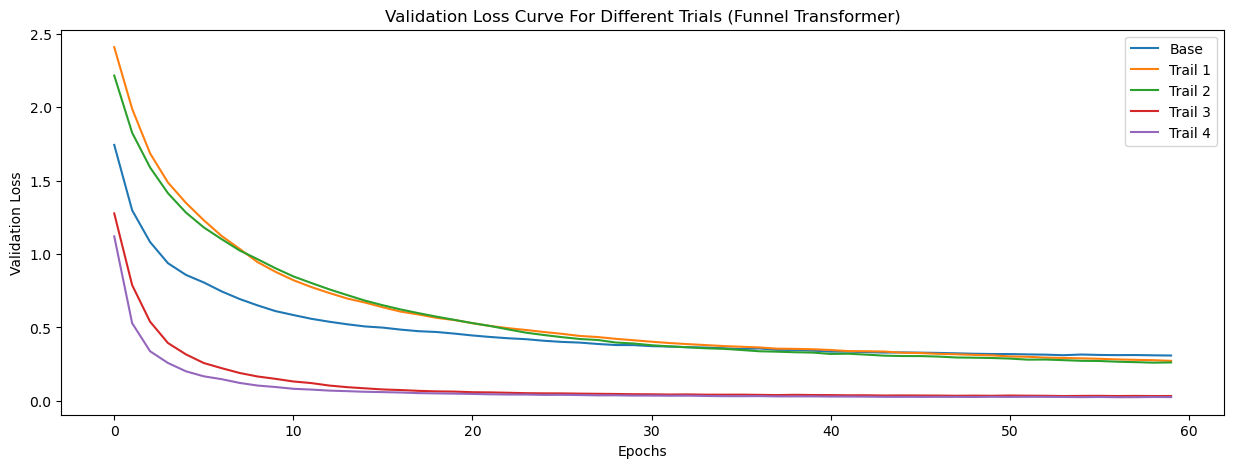

In [16]:
plt.figure(figsize=(15,5))
plt.plot(range(60), learning_rate_base[:60], label = "Base") 
plt.plot(range(60), learning_rate_t1[:60], label = "Trail 1") 
plt.plot(range(60), learning_rate_t2[:60], label = "Trail 2") 
plt.plot(range(60), learning_rate_t3[:60], label = "Trail 3") 
plt.plot(range(60), learning_rate_t4[:60], label = "Trail 4")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curve For Different Trials (Funnel Transformer)")
plt.legend() 
plt.show()